In [2]:
import os
import string
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

2.0.1


In [4]:
all_characters= list(string.digits) + list(string.ascii_lowercase) 

print(all_characters)

nchar = len(all_characters)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [5]:
path_to_dataset = f"./captcha_dataset"

captchas = os.listdir(path_to_dataset)

# Array for pictures with added dimention
X = np.zeros((len(captchas), 50, 200, 1))

# Labels as strings
y_strings = [] 

for i, img_name in enumerate(captchas):

    y_strings.append(img_name[:5]) # Take off .png

    new_path = f"{path_to_dataset}/{captchas[i]}"

    image = Image.open(new_path)

    array_image = np.array(image) / 255 # Normalize
    
    array_image = np.reshape(array_image[:, :, 0], (50, 200, 1))

    X[i] = (array_image)

In [6]:
# Make label array

y = np.zeros((5 , len(captchas) , nchar))
#            5     * 1070    * 36
#            Digit * Picture * Digit label


for i, captcha in enumerate(y_strings):
   
    temp_label =np.zeros((5,nchar))

    for j, character in enumerate(captcha):
     
        character_index =  all_characters.index(character)

        temp_label[j, character_index] = 1
        
    y[:, i, :] = temp_label

In [7]:
class CaptchaModel(nn.Module):
    def __init__(self, nchar):
        super(CaptchaModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.mp1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.mp2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(32)
        self.mp3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.fc_shared = nn.Linear(4800, 64)
        self.fc_outputs = nn.ModuleList([nn.Linear(64, nchar) for _ in range(5)])

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.mp1(x)
        
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.mp2(x)
        
        x = self.conv3(x)
        x = nn.functional.relu(x)
        x = self.bn(x)
        x = self.mp3(x)
        
        # Flatten the tensor
        x = x.view(x.size(0), -1)
        
        x = self.fc_shared(x)
        x = nn.functional.relu(x)
        
        outputs = [output_layer(x) for output_layer in self.fc_outputs]
        return outputs


model = CaptchaModel(nchar)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [8]:
train_pct = round(len(X) * .8)

# Convert your data and labels to PyTorch tensors
X_tensor = torch.FloatTensor(X.transpose(0, 3, 1, 2))
y_tensor = torch.LongTensor(y) 

# Split the data into training and validation sets
X_train = X_tensor[:train_pct]
y_train = y_tensor[:, :train_pct, :]

X_val = X_tensor[train_pct:]
y_val =y_tensor[:, train_pct:, :]

train_dataset = TensorDataset(
    X_train, 
    y_train[0], 
    y_train[1], 
    y_train[2], 
    y_train[3], 
    y_train[4]
)

test_dataset = TensorDataset(
    X_val, 
    y_val[0], 
    y_val[1], 
    y_val[2], 
    y_val[3], 
    y_val[4]
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [9]:
# Turn labels into indexes to compare to predicted
y_test_indexes = torch.zeros((214,5,1))

for i in range(214):

    temp_label = torch.zeros((5,1))
    
    for j in range(5):

        itemindex = np.where(y_val[:,i][j] == 1 )[0][0]

        temp_label[j] = itemindex

    y_test_indexes[i] = temp_label

In [11]:
acc_cap = []
acc_dig = []
metric_loss = []

# Training loop
num_epochs = 200  
for epoch in range(num_epochs):
    model.train()  
    running_loss = 0.0
    
    # Iterate over batches of the training dataset
    for inputs, target0, target1, target2, target3, target4 in train_loader:
        optimizer.zero_grad()  
        
        outputs = model(inputs)
        
        # Calculate the loss for each output and sum them up
        targets = [target0, target1, target2, target3, target4]
        losses = [criterion(output, target.float()) for output, target in zip(outputs, targets)]
        loss = sum(losses)        
        
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
    
    pred_labels = torch.zeros((len(X_val), 5, 1))

    with torch.no_grad():
        model.eval()

        for i,input in enumerate(X_val):
            
            temp_labels = torch.zeros((5, 1))

            outputs = model(input.unsqueeze(0))

            for j,num in enumerate(outputs):
                
                temp_labels[j] = num.argmax(dim=1)

            pred_labels[i] = temp_labels 

    entire_correct = 0
    entire_total = 0 
    for i in range(y_val.size()[1]):
        a = y_test_indexes[i] == pred_labels[i]
        
        entire_total+=1
        if False not in a:
            entire_correct +=1

    acc_cap.append(entire_correct / entire_total * 100)    

    digits_correct = 0
    total_digits = 0

    for i in range(y_val.size()[1]):

        for j in range(5):

            total_digits += 1
            if y_test_indexes[i][j] == pred_labels[i][j]:
                digits_correct += 1        

    acc_dig.append(digits_correct / total_digits * 100)
    metric_loss.append(running_loss / len(train_loader))
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {running_loss / len(train_loader)}")

Epoch [10/200] - Loss: 4.634901223359285
Epoch [20/200] - Loss: 0.10148418322205544
Epoch [30/200] - Loss: 0.011129300179028953
Epoch [40/200] - Loss: 0.0058119224073986215
Epoch [50/200] - Loss: 0.003637829476415559
Epoch [60/200] - Loss: 0.002496354437122742
Epoch [70/200] - Loss: 0.0017967610318144714
Epoch [80/200] - Loss: 0.0013429834119354684
Epoch [90/200] - Loss: 0.0010303614048839168
Epoch [100/200] - Loss: 0.0008078315209045455
Epoch [110/200] - Loss: 0.0006414915723898621
Epoch [120/200] - Loss: 0.0005139737450345247
Epoch [130/200] - Loss: 0.000413639534532127
Epoch [140/200] - Loss: 0.00033534855389950316
Epoch [150/200] - Loss: 0.00027452755656903955
Epoch [160/200] - Loss: 0.0002261904581380939
Epoch [170/200] - Loss: 0.00018659060555768924
Epoch [180/200] - Loss: 0.00015419562044337876
Epoch [190/200] - Loss: 0.00012807904271607253
Epoch [200/200] - Loss: 0.00010699002585304832


In [12]:
# Gets predicted labels from test dataset
pred_labels = torch.zeros((len(X_val), 5, 1))

with torch.no_grad():
    model.eval()

    for i, data in enumerate(X_val):
        
        temp_labels = torch.zeros((5, 1))

        outputs = model(data.unsqueeze(0))

        for j,num in enumerate(outputs):
            
            temp_labels[j] = num.argmax(dim=1)

        pred_labels[i] = temp_labels    

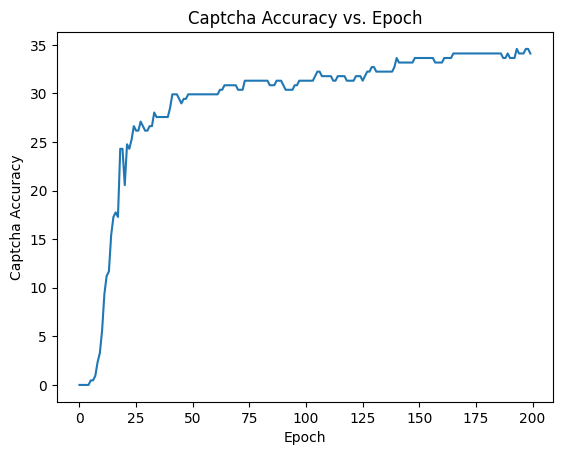

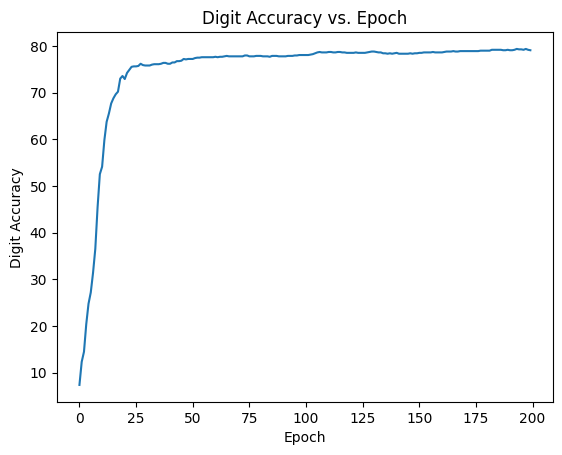

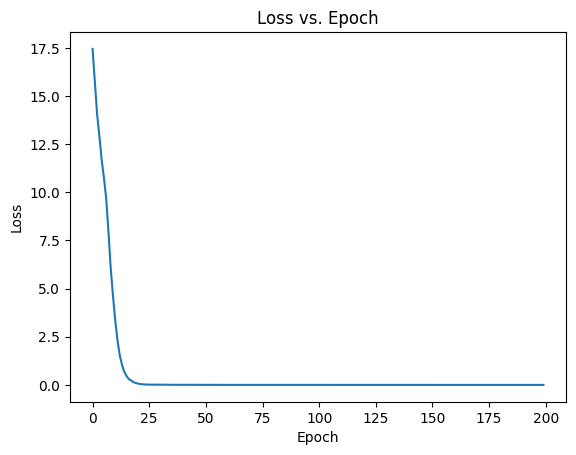

In [13]:
plt.plot(list(range(len(acc_cap))), acc_cap)
plt.title('Captcha Accuracy vs. Epoch')
plt.ylabel('Captcha Accuracy')
plt.xlabel('Epoch')
plt.show()

plt.plot(list(range(len(acc_dig))), acc_dig)
plt.title('Digit Accuracy vs. Epoch')
plt.ylabel('Digit Accuracy')
plt.xlabel('Epoch')
plt.show()

plt.plot(list(range(len(metric_loss))), metric_loss)
plt.title('Loss vs. Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()


In [14]:
# Check for entire captchas correctly labeled

entire_correct = 0
entire_total = 0 
for i in range(y_val.size()[1]):
    a = y_test_indexes[i] == pred_labels[i]
    
    entire_total+=1
    if False not in a:
        entire_correct +=1

print(entire_correct / entire_total * 100)


34.112149532710276


In [15]:
# Check how many digits correctly labeled

digits_correct = 0
total_digits = 0

for i in range(y_val.size()[1]):

    for j in range(5):
        total_digits += 1 
        if y_test_indexes[i][j] ==pred_labels[i][j]:
            digits_correct +=1    

print(digits_correct / total_digits * 100)

79.06542056074767
